In [2]:
import optuna
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import dump, Dataset, Reader, accuracy, SVD
from surprise.model_selection import train_test_split, KFold
from sklearn.model_selection import train_test_split as tts

np.random.seed(42)

In [7]:
import warnings
warnings.filterwarnings('ignore')

### Загрузка и обработка данных

In [6]:
train = pd.read_csv('train_joke_df.csv')
train.head(5)

,UID,JID,Rating
0,18029,6,-1.26
1,3298,64,-4.17
2,3366,58,0.92
3,12735,92,3.69
4,11365,38,-6.60


In [8]:
print('Number of unique users:', len(train['UID'].unique()))
print('Number of unique jokes:', len(train['JID'].unique()))

Number of unique users: 24983
Number of unique jokes: 100


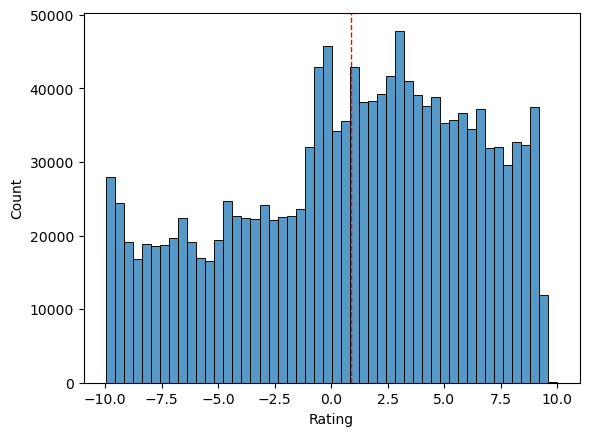

In [9]:
# распределение оценок
sns.histplot(train, x='Rating', bins=50)
plt.axvline(x=train.Rating.mean(), color='red', ls='--', lw=1.0)

<AxesSubplot:xlabel='UID', ylabel='Count'>

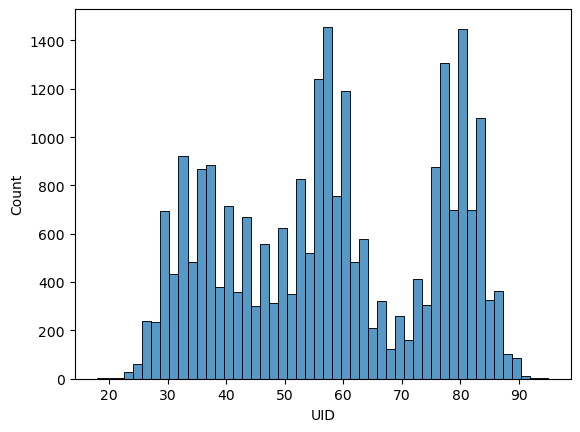

In [10]:
# распределение количества оценок каждого пользователя
sns.histplot(train['UID'].value_counts(), bins=50)

In [11]:
train = train.sort_values(by=['UID', 'JID'])
train = train.reset_index(drop=True)

In [12]:
reader = Reader(rating_scale=(-10, 10))
data = Dataset.load_from_df(train[['UID', 'JID', 'Rating']], reader)

trainset_data = data.build_full_trainset()
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)

### Подбор параметров и обучение модели

In [ ]:
def objective_SVD(trial):   
    
    reg_bu = trial.suggest_float("reg_bu", 1e-7, 0.01, log=True)
    reg_bi = trial.suggest_float("reg_bi", 1e-7, 0.01, log=True)
    reg_pu = trial.suggest_float("reg_pu", 1e-6, 0.01, log=True)
    reg_qi = trial.suggest_float("reg_qi", 0.01, 1, log=True)
    
    lr_bu = trial.suggest_float("lr_bu", 0.0001, 0.01, log=True)
    lr_bi = trial.suggest_float("lr_bi", 0.0001, 0.01, log=True)
    lr_pu = trial.suggest_float("lr_pu", 0.0001, 0.01, log=True)
    lr_qi = trial.suggest_float("lr_qi", 0.0001, 0.01, log=True)
    
    n_factors = trial.suggest_int("n_factors", 100, 2000)
    n_epochs = trial.suggest_int("n_epochs", 10, 50)

    svd = SVD(
       reg_bu=reg_bu, reg_bi=reg_bi, reg_pu=reg_pu, reg_qi=reg_qi,
       lr_bu=lr_bu, lr_bi=lr_bi, lr_pu=lr_pu, lr_qi=lr_qi,
       n_factors=n_factors, n_epochs=n_epochs
    )

    kf = KFold(n_splits=3)
    rmse = []
    
    for trainset, testset in kf.split(data):

      svd.fit(trainset)
      predictions = svd.test(testset)
      rmse.append(accuracy.rmse(predictions))

    score = np.array(rmse).mean()
    return score


study = optuna.create_study(direction="minimize")
study.optimize(objective_SVD, n_trials=10)

In [42]:
print('Best trial:')
trial = study.best_trial
print('  RMSE:', trial.value)
print('  Params:')
for key, value in trial.params.items():
    print('  {}: {}'.format(key, value))

Best trial:
  RMSE: 4.062190741553736
  Params:
  reg_bu: 7.414020222718965e-06
  reg_bi: 5.666394543081889e-07
  reg_pu: 8.503717881303539e-06
  reg_qi: 0.9837451076740744
  lr_bu: 0.0008917080658915639
  lr_bi: 0.0003414903648975878
  lr_pu: 0.005011884639660503
  lr_qi: 0.0003968700657645565
  n_factors: 565
  n_epochs: 41


In [35]:
params = trial.params
svd = SVD(**params)
svd.fit(trainset)

predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 4.0187


4.018724787143538

In [ ]:
# сохранение модели
file_name = 'svd_model_optuna'
dump.dump(file_name, algo=svd)

In [3]:
_, svd = dump.load('svd_model_optuna')

### Для отправки на тестирование

In [10]:
test = pd.read_csv('test_joke_df_nofactrating.csv', index_col=0)
test.head(5)

,UID,JID
InteractionID,,
0,11228,39
1,21724,85
2,16782,56
3,12105,42
4,14427,2


In [11]:
test['Rating'] = test[['UID', 'JID']].apply(
    lambda x: svd.predict(x[0], x[1], verbose=False).est, 
    axis = 1
)
test['Rating'].to_frame().head(5)

,Rating
InteractionID,
0,3.119531
1,-7.189405
2,-1.074549
3,7.074900
4,6.205707


In [ ]:
# файл для отправки в Kaggle
test['Rating'].to_frame().to_csv('svd_model_optuna.csv')

### Получение рекомендаций

In [4]:
test = pd.read_csv('test_joke_df_nofactrating.csv', index_col=0)
test.index.name = None

In [13]:
# создаем список всех пар пользователь-шутка
users = range(1, len(train['UID'].unique()) + 1)
jokes = range(1, len(train['JID'].unique()) + 1)
all_combinations = [(user, joke) for user in users for joke in jokes]
df_all = pd.DataFrame(all_combinations, columns=['UID', 'JID'])

# находим отсутствующие пары пользователь-шутка
df_missing = df_all.merge(
    train[['UID', 'JID']], 
    on=['UID', 'JID'], 
    how='left', 
    indicator='merged_train'
)
df_missing = df_missing.merge(
    test, 
    on=['UID', 'JID'], 
    how='left', 
    indicator='merged_test'
)
df_missing = df_missing.loc[
    (df_missing['merged_test'] != 'both') & 
    (df_missing['merged_train'] != 'both')
]
df_missing = df_missing.drop(columns=['merged_train', 'merged_test'])
print('Number of missing pairs:', len(df_missing))

test = pd.concat([test, df_missing], ignore_index=True)

Number of missing pairs: 687845


In [38]:
test['Rating'] = test[['UID', 'JID']].apply(
    lambda x: svd.predict(x[0], x[1], verbose=False).est, 
    axis = 1
)

In [39]:
def get_top_jokes(df, k):
    # сортировка по рейтингу
    sorted_df = df.sort_values(by=['UID', 'Rating'], ascending=[True, False])
    grouped_df = sorted_df.groupby('UID')

    # создание словаря для каждого пользователя
    user_jokes = {}
    for index, row in sorted_df.iterrows():
        uid = int(row['UID'])
        jid = int(row['JID'])

        if uid not in user_jokes:
            top_joke_dict = {jid: row['Rating']}
            user_jokes[uid] = [top_joke_dict, [jid]]

        elif len(user_jokes[uid][1]) < k:
            user_jokes[uid][1].append(jid)

    # создание списка для всех пользователей
    result = []
    for uid, jokes in user_jokes.items():
        result.append([uid, jokes])
    
    return result, user_jokes

In [40]:
result, user_jokes = get_top_jokes(test, 10)

# сохранение результата в CSV файл
result_df = pd.DataFrame(result, columns=['UID', 'top_rec'])
result_df.to_csv('output.csv', index=False)

In [41]:
cnt = 0
print('UID', 'top_rec')

for uid, top_rec in user_jokes.items():
    print(uid, top_rec)
    cnt += 1

    if cnt == 10:
        break

UID top_rec
1 [{89: 2.501450723406753}, [89, 49, 65, 31, 72, 76, 93, 46, 88, 91]]
2 [{100: 5.03565996747953}, [100, 80, 75, 52, 30, 5, 72, 98, 17, 14]]
3 [{27: 9.228962913149193}, [27, 38, 89, 47, 72, 10, 63, 82, 14, 53]]
4 [{83: 5.018820453811076}, [83, 100, 54, 98, 81, 72, 12, 69, 52, 32]]
5 [{6: 5.71958078607887}, [6, 72, 29, 76, 34, 97, 78, 91, 80, 87]]
6 [{1: -2.6326811440728504}, [1, 15, 97, 16, 37, 100, 3, 69, 62, 46]]
7 [{50: 7.530063678099289}, [50, 62, 89, 54, 11, 38, 83, 93, 81, 88]]
8 [{29: 3.3373914917805125}, [29, 1, 69, 48, 7, 5, 66, 56, 54, 60]]
9 [{69: 3.042545129642695}, [69, 32, 89, 47, 21, 87, 29, 14, 28, 70]]
10 [{48: 6.136198315629558}, [48, 21, 69, 89, 72, 65, 100, 47, 93, 76]]
